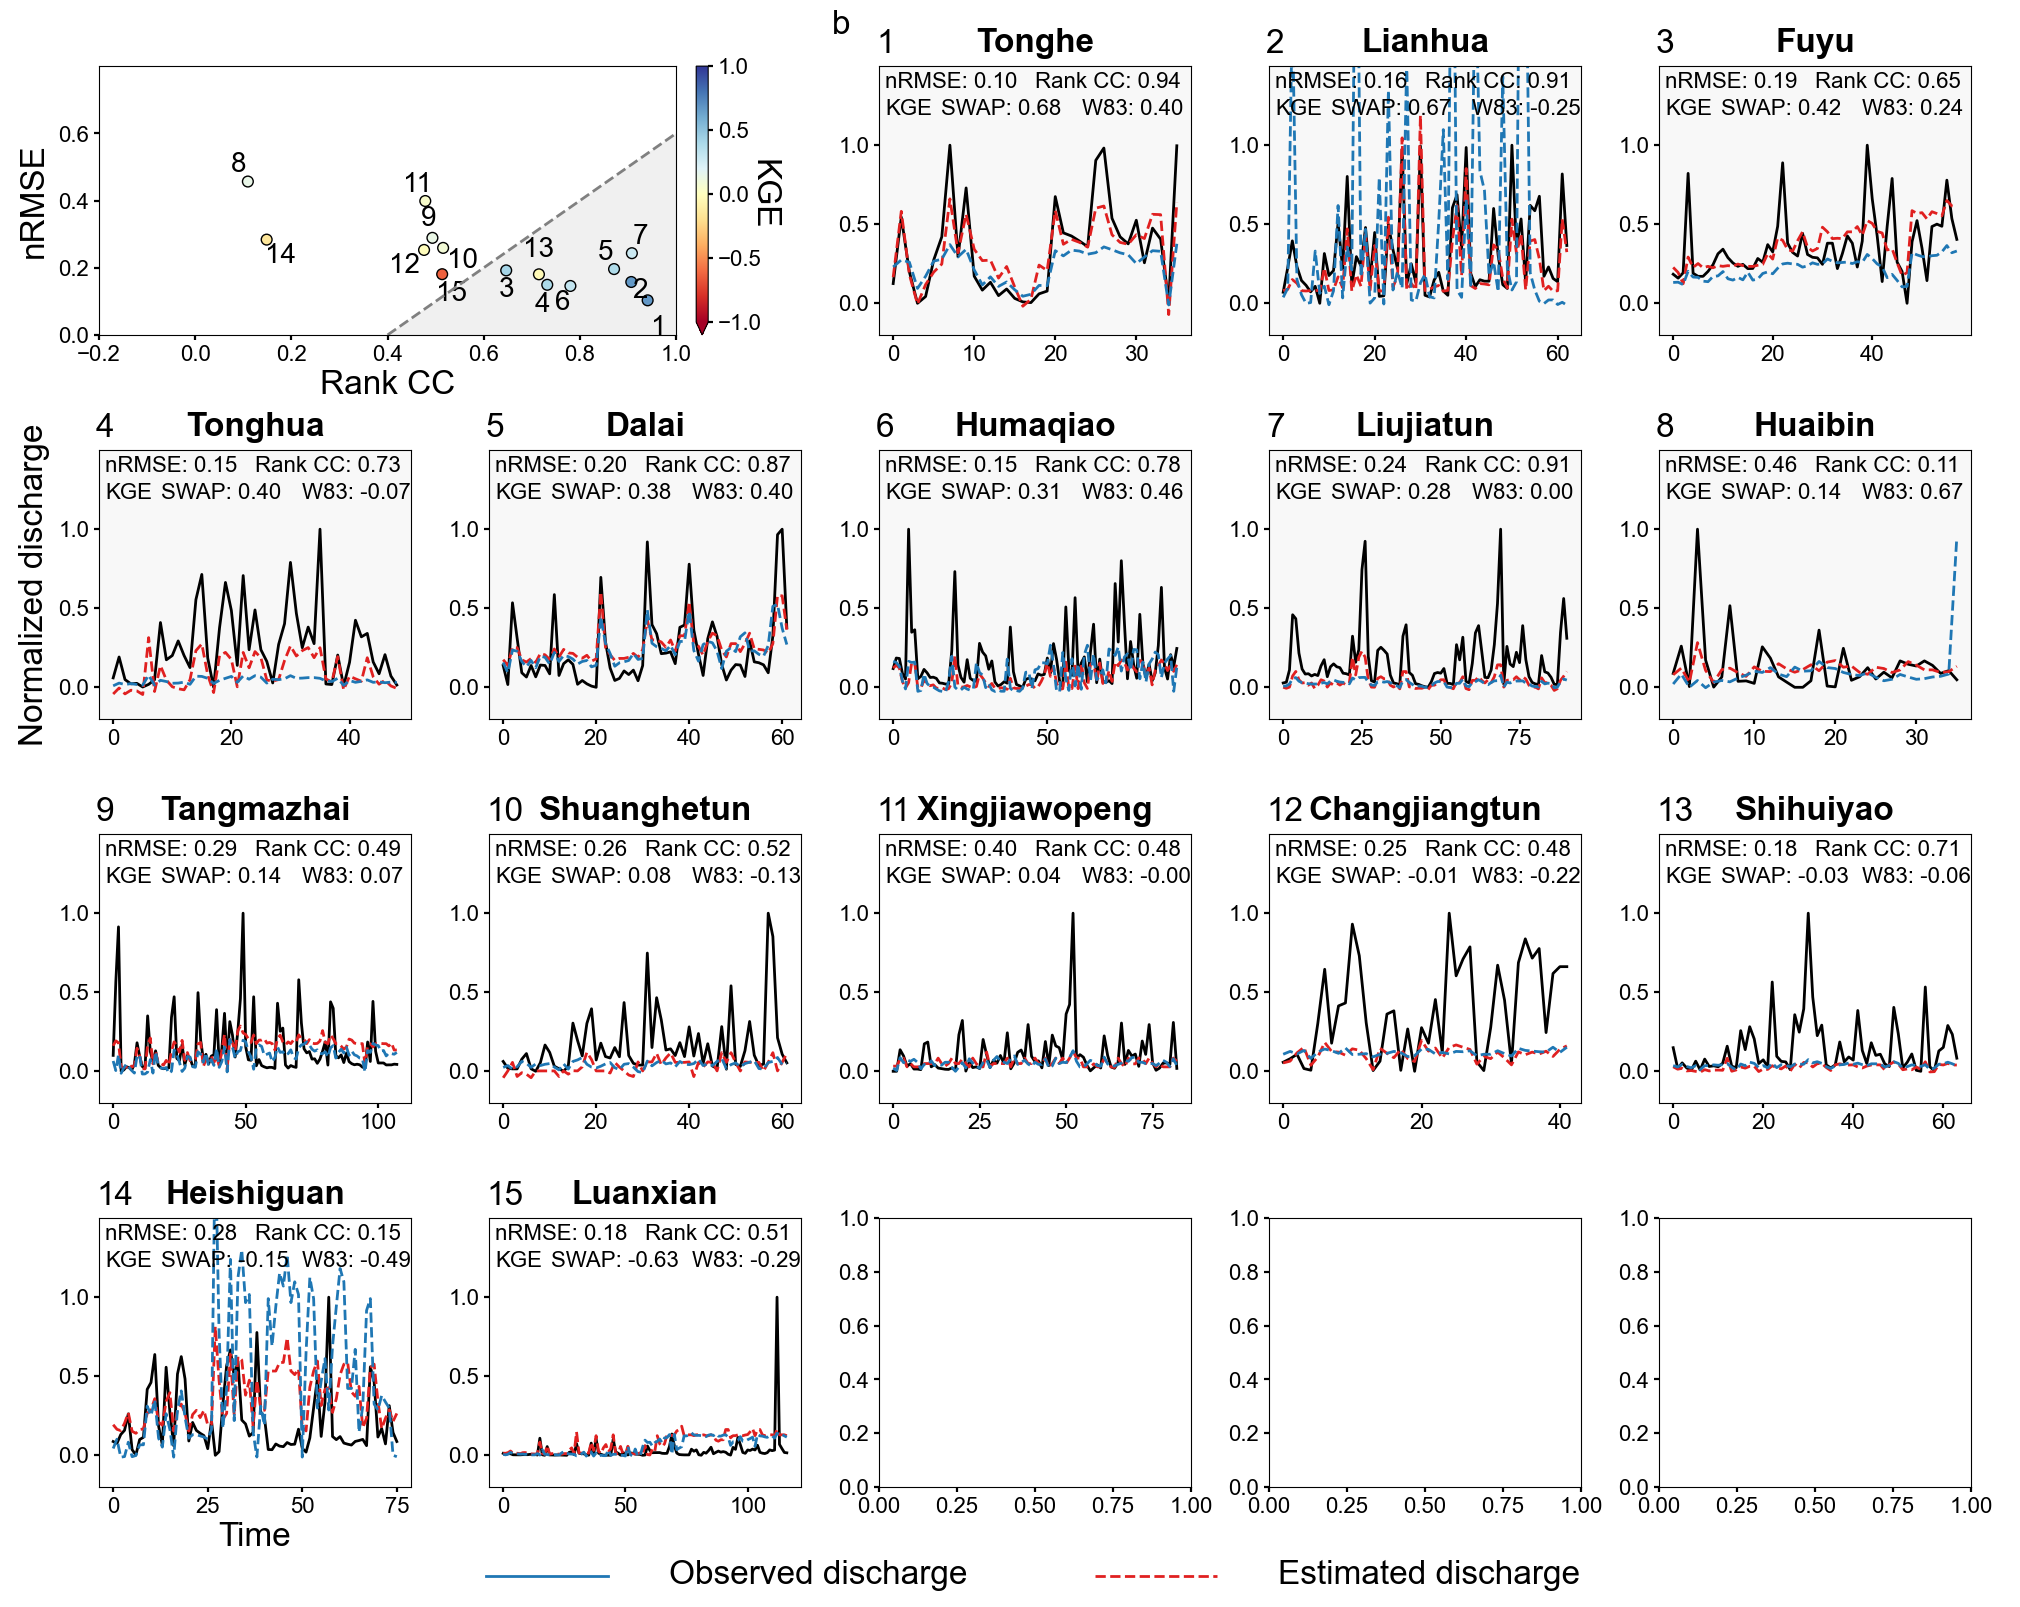

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors as mpc
from scipy.stats import spearmanr
from adjustText import adjust_text
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 16
plt.rcParams['axes.titlesize'] = 24
plt.rcParams['axes.labelsize'] = 24
plt.rcParams['axes.titlepad'] = 10
#plt.rcParams['axes.labelpad'] = -2
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['xtick.major.width'] = 1.6
plt.rcParams['ytick.major.width'] = 1.6
#plt.rcParams['axes.facecolor'] = '#F8F8F8'
#plt.rcParams['figure.facecolor'] = '#F8F8F8'

N = 4
M = 5
BOUNDS = [0.1, 0.12, 0.8, 0.7]
MARGIN_LEFT, MARGIN_RIGHT, MARGIN_BOT, MARGIN_TOP = 0.025, 0, 0.04, 0
subplot_width = (1 - MARGIN_LEFT - MARGIN_RIGHT) / M
subplot_height = (1 - MARGIN_TOP - MARGIN_BOT) / N
AXES_LEFT = MARGIN_LEFT + (np.arange(M) + BOUNDS[0]) * subplot_width
AXES_BOT = MARGIN_BOT + (np.arange(N) + BOUNDS[1]) * subplot_height
AXES_WIDTH = subplot_width * BOUNDS[2]
AXES_HEIGHT = subplot_height * BOUNDS[3]
fig = plt.figure(figsize=(20,16))
ax = [[plt.axes([AXES_LEFT[j], AXES_BOT[i], AXES_WIDTH, AXES_HEIGHT])\
       for j in range(M)] for i in np.arange(N-1,-1,-1)]

df_q_all = pd.read_csv('./3-process/5.q_kge_med_modified_q50_iqr_node_1.5_noqa_VersionD.csv').rename(columns = {'kge':'KGE','nrmse':'nRMSE'}) 
df_q_all = df_q_all[~df_q_all['stationid'].isin(['longmenzhen'])].reset_index(drop=True)
df_metrics = pd.read_csv('./4-validation/swot_hypso_metrics.csv')
df_metrics = df_metrics[~df_metrics['stationid'].isin(['longmenzhen'])].set_index('stationid')
stations = df_q_all.drop_duplicates(subset='stationid', keep='first').sort_values('KGE', ascending=False).reset_index(drop=True)['stationid']

df_q_w83_all = pd.read_csv('q_83.csv')
df_metrics_w83 = pd.read_csv('validation_83_datematch.csv').set_index('stationid')

# main
for panel in range(2, 17):  # Panel range: 2 to 14 (13 panels in total)
    s = stations[panel-2]
    i, j = int(panel / M), panel % M
    df_q = df_q_all[df_q_all['stationid']==s].copy().sort_values('date').reset_index(drop=True).drop_duplicates(subset='date')
    df_q_w83 = df_q_w83_all[df_q_w83_all['stationid']==s]
    df_q_w83 = df_q_w83[df_q_w83['date'].isin(df_q['date'])].drop_duplicates(subset='date')
    kge_w83= df_metrics_w83.loc[s,'KGE']
    kge = df_q.iloc[0]['KGE']
    corr_val = spearmanr(df_q['width'], df_q['qobs'])
    nrmse = df_metrics.loc[s,'nrmse']
    df_metrics.loc[s,'kge'] = kge
    df_metrics.loc[s,'corr'] = corr_val.statistic
    df_metrics.loc[s,'number'] = panel-1
    qmin, qmax = df_q['qobs'].min(), df_q['qobs'].max()
    Q_normalize = (df_q['qobs'] - qmin) / (qmax - qmin)
    Q_est_normalize = (df_q['Q_est'] - qmin) / (qmax - qmin)
    Q_est_normalize_w83 = (df_q_w83['83Q'] - qmin) / (qmax - qmin)

    ax[i][j].plot(np.arange(len(df_q)), Q_normalize, color='black', lw=2, zorder=0)
    ax[i][j].plot(np.arange(len(df_q)), Q_est_normalize, color='#E02020', lw=2, ls='--', zorder=1)
    ax[i][j].plot(np.arange(len(df_q)), Q_est_normalize_w83, color='#1f77b4', lw=2, ls='--', zorder=1)
    
    y0, ymax = ax[i][j].get_ylim()
    ymax = max(np.max(Q_normalize), np.max(Q_est_normalize))
    ax[i][j].set_ylim(y0, 1.3 * ymax)
    ax[i][j].set_yticks([0,0.5,1])
    ax[i][j].set_title(s.capitalize(), fontweight='bold')
    if panel <= 9: ax[i][j].set_facecolor('#F8F8F8')

    x0, xmax = ax[i][j].get_xlim()
    y0, ymax = ax[i][j].get_ylim()
    fig_w = xmax - x0
    # 固定y轴范围
    ax[i][j].set_ylim(-0.2, 1.5)
    
    # 获取固定的ylim范围
    ymin, ymax = ax[i][j].get_ylim()
    fig_h = ymax-ymin
    # 计算文本位置时，使用固定的y轴范围
    ax[i][j].text(x0 + 0.02 * fig_w, ymin + 0.88 * (ymax - ymin), 'KGE', ha='left', va='top')
    ax[i][j].text(x0 + 0.20 * fig_w, ymin + 0.88 * (ymax - ymin), 'SWAP: %.2f' % kge, ha='left', va='top')
    ax[i][j].text(x0 + 0.65 * fig_w, ymin + 0.88 * (ymax - ymin), 'W83: %.2f' % kge_w83, ha='left', va='top')
    ax[i][j].text(x0 + 0.02 * fig_w, ymin + 0.98 * (ymax - ymin), 'nRMSE: %.2f' % nrmse, ha='left', va='top')
    ax[i][j].text(x0 + 0.50 * fig_w, ymin + 0.98 * (ymax - ymin), 'Rank CC: %.2f' % corr_val.statistic, ha='left', va='top')
    
    # 在子图的左下角显示panel编号
    ax[i][j].text(x0 - 0.01 * fig_w, ymin + 1.025 * (ymax - ymin), '%d' % (panel - 1), fontsize=24, ha='left', va='bottom')
    
    # 保持固定的y轴范围
    ax[i][j].set_ylim(-0.2, 1.5)

    if panel == 0:
        ax[i][j].text(x0-0.1*fig_w, y0+1.05*fig_h, 'a', fontsize=24, ha='left', va='bottom')
    if panel == 2:
        ax[i][j].text(x0-0.15*fig_w, y0+1.05*fig_h, 'b', fontsize=24, ha='left', va='bottom')

ax[N-1][0].set_xlabel('Time', labelpad=4)
ax[1][0].set_ylabel('Normalized discharge', labelpad=6)
ax[0][0].axis('off')
ax[0][1].axis('off')


# kge scatter
ax[0][0] = plt.axes([AXES_LEFT[0], AXES_BOT[N-1], 1.85*AXES_WIDTH, AXES_HEIGHT])
cax = plt.axes([AXES_LEFT[0]+1.85*AXES_WIDTH+0.01, AXES_BOT[N-1], 0.006, AXES_HEIGHT])
ax[0][0].scatter(df_metrics['corr'], df_metrics['nrmse'], c=df_metrics['kge'], cmap='RdYlBu',
                 s=60, lw=1, ec='black', vmin=-1, vmax=1)
ax[0][0].plot([0.4,1], [0,0.6], color='#808080', lw=2, ls='--')
anno = [ax[0][0].text(x=df_metrics.loc[i,'corr'], y=df_metrics.loc[i,'nrmse'], s=int(df_metrics.loc[i,'number']),
                      fontsize=20, ha='center', va='center', zorder=1) for i in df_metrics.index]
adjust_text(texts=anno, expand=(1.5,1.5), pull_threshold=50, explode_radius=100, ax=ax[0][0])
ax[0][0].fill_between([0.4,1], [0,0], [0,0.6], color='#F0F0F0', zorder=-1)
#ax[0][0].fill_between([-0.2,1], [0,0], [0.6,0.6], color='#F0F0F0', zorder=-2)

norm = mpc.Normalize(vmin=-1, vmax=1)
sm = plt.cm.ScalarMappable(cmap='RdYlBu', norm=norm)
cbar = fig.colorbar(sm, cax=cax, extend='min')
#cbar.ax.tick_params(labelsize=9)
cbar.set_label('KGE', rotation=270, labelpad=12)

ax[0][0].set_yticks(np.arange(0,0.7,0.2))
ax[0][0].set_xlabel('Rank CC', labelpad=4)
ax[0][0].set_ylabel('nRMSE', labelpad=6)
ax[0][0].set_xlim(-0.2,1)
ax[0][0].set_ylim(0,0.8)


# legend
ax_l = plt.axes([0,0,1,0.04])
ax_l.plot([0.5,1.5], [1,1], color='#1f77b4', lw=2)
ax_l.plot([5.5,6.5], [1,1], color='#E02020', lw=2, ls='--')

ax_l.text(2, 1, 'Observed discharge', fontsize=24, ha='left', va='center')
ax_l.text(7, 1, 'Estimated discharge', fontsize=24, ha='left', va='center')

ax_l.set_xlim(-3.4,13)
ax_l.set_ylim(0.5,2)
ax_l.axis('off')


#plt.show()
plt.savefig('Fig8_w83.png', dpi=200)

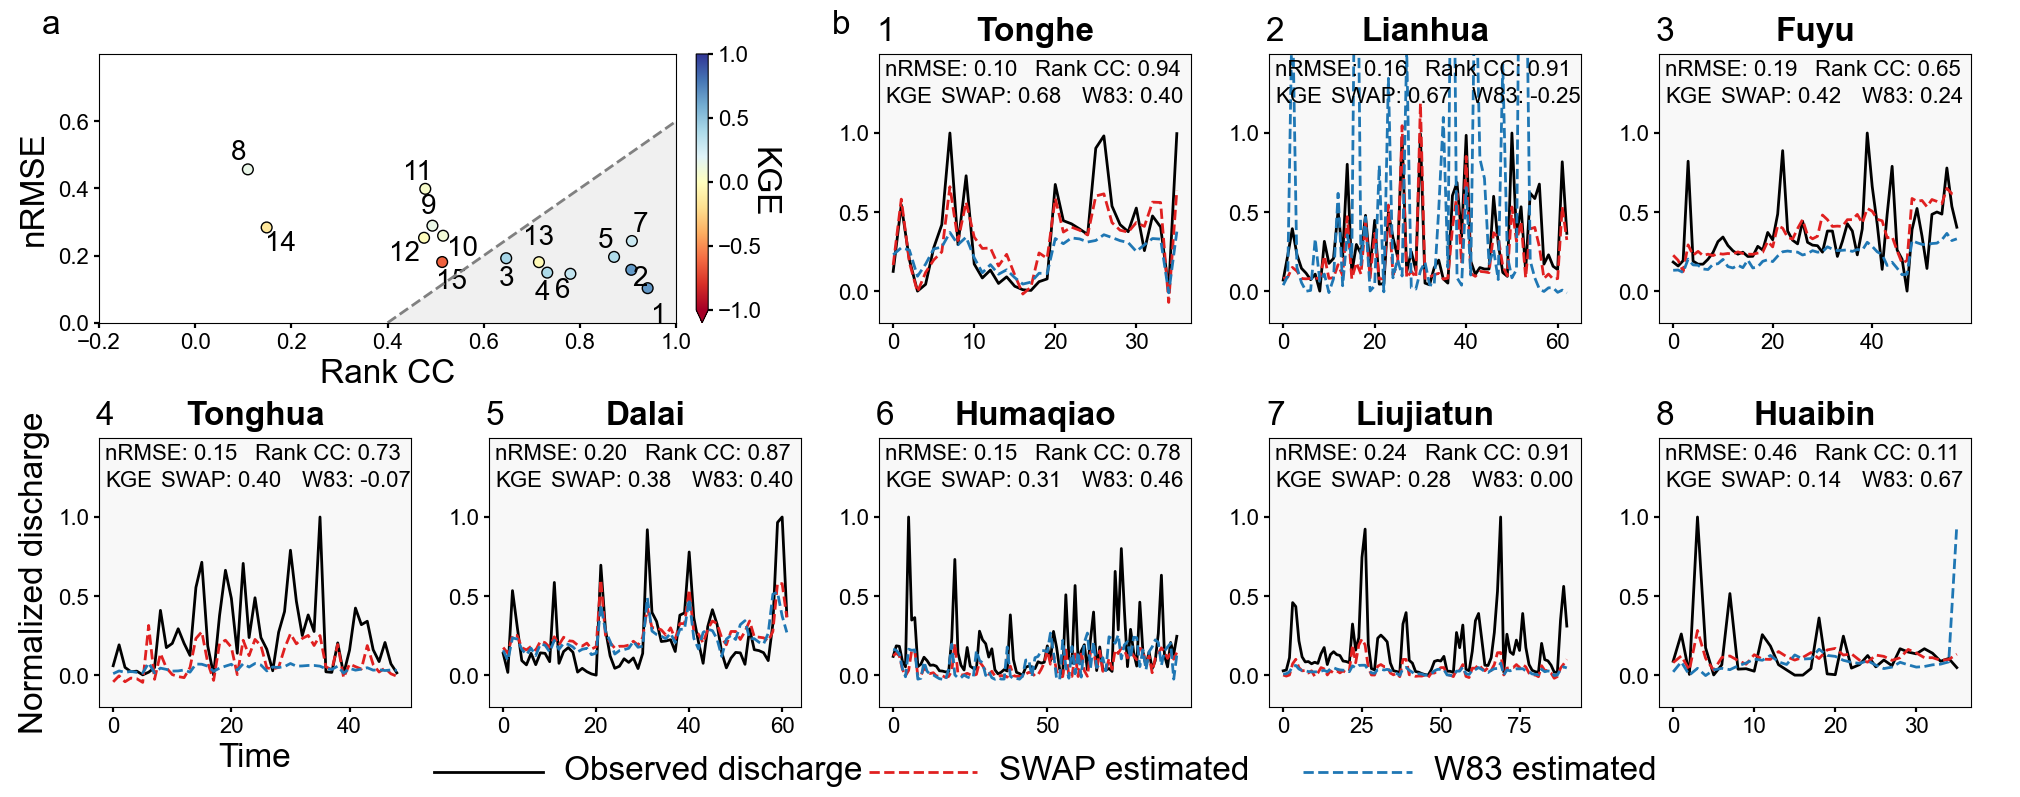

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors as mpc
from scipy.stats import spearmanr
from adjustText import adjust_text
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 16
plt.rcParams['axes.titlesize'] = 24
plt.rcParams['axes.labelsize'] = 24
plt.rcParams['axes.titlepad'] = 10
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['xtick.major.width'] = 1.6
plt.rcParams['ytick.major.width'] = 1.6

N = 2  # 2 rows
M = 5  # 5 columns
BOUNDS = [0.1, 0.12, 0.8, 0.7]
MARGIN_LEFT, MARGIN_RIGHT, MARGIN_BOT, MARGIN_TOP = 0.025, 0, 0.04, 0
subplot_width = (1 - MARGIN_LEFT - MARGIN_RIGHT) / M
subplot_height = (1 - MARGIN_TOP - MARGIN_BOT) / N
AXES_LEFT = MARGIN_LEFT + (np.arange(M) + BOUNDS[0]) * subplot_width
AXES_BOT = MARGIN_BOT + (np.arange(N) + BOUNDS[1]) * subplot_height
AXES_WIDTH = subplot_width * BOUNDS[2]
AXES_HEIGHT = subplot_height * BOUNDS[3]
fig = plt.figure(figsize=(20, 8))  # Adjusted height for 2 rows
ax = [[plt.axes([AXES_LEFT[j], AXES_BOT[i], AXES_WIDTH, AXES_HEIGHT])\
       for j in range(M)] for i in np.arange(N-1,-1,-1)]

df_q_all = pd.read_csv('./3-process/5.q_kge_med_modified_q50_iqr_node_1.5_noqa_VersionD.csv').rename(columns = {'kge':'KGE','nrmse':'nRMSE'}) 
df_q_all = df_q_all[~df_q_all['stationid'].isin(['longmenzhen'])].reset_index(drop=True)
df_metrics = pd.read_csv('./4-validation/swot_hypso_metrics.csv')
df_metrics = df_metrics[~df_metrics['stationid'].isin(['longmenzhen'])].set_index('stationid')
stations = df_q_all.drop_duplicates(subset='stationid', keep='first').sort_values('KGE', ascending=False).reset_index(drop=True)['stationid']

df_q_w83_all = pd.read_csv('q_83.csv')
df_metrics_w83 = pd.read_csv('validation_83_datematch.csv').set_index('stationid')

# First loop: calculate metrics for ALL 15 stations (for scatter plot)
for idx in range(15):
    s = stations[idx]
    df_q = df_q_all[df_q_all['stationid']==s].copy().sort_values('date').reset_index(drop=True).drop_duplicates(subset='date')
    kge = df_q.iloc[0]['KGE']
    corr_val = spearmanr(df_q['width'], df_q['qobs'])
    nrmse = df_metrics.loc[s,'nrmse']
    df_metrics.loc[s,'kge'] = kge
    df_metrics.loc[s,'corr'] = corr_val.statistic
    df_metrics.loc[s,'number'] = idx + 1  # 1-15

# Second loop: plot time series for panels 2-9 (8 panels for 2 rows)
for panel in range(2, 10):
    s = stations[panel-2]
    i, j = int(panel / M), panel % M
    df_q = df_q_all[df_q_all['stationid']==s].copy().sort_values('date').reset_index(drop=True).drop_duplicates(subset='date')
    df_q_w83 = df_q_w83_all[df_q_w83_all['stationid']==s]
    df_q_w83 = df_q_w83[df_q_w83['date'].isin(df_q['date'])].drop_duplicates(subset='date')
    kge_w83= df_metrics_w83.loc[s,'KGE']
    kge = df_q.iloc[0]['KGE']
    corr_val = spearmanr(df_q['width'], df_q['qobs'])
    nrmse = df_metrics.loc[s,'nrmse']
    qmin, qmax = df_q['qobs'].min(), df_q['qobs'].max()
    Q_normalize = (df_q['qobs'] - qmin) / (qmax - qmin)
    Q_est_normalize = (df_q['Q_est'] - qmin) / (qmax - qmin)
    Q_est_normalize_w83 = (df_q_w83['83Q'] - qmin) / (qmax - qmin)

    ax[i][j].plot(np.arange(len(df_q)), Q_normalize, color='black', lw=2, zorder=0)
    ax[i][j].plot(np.arange(len(df_q)), Q_est_normalize, color='#E02020', lw=2, ls='--', zorder=1)
    ax[i][j].plot(np.arange(len(df_q)), Q_est_normalize_w83, color='#1f77b4', lw=2, ls='--', zorder=1)
    
    y0, ymax = ax[i][j].get_ylim()
    ymax = max(np.max(Q_normalize), np.max(Q_est_normalize))
    ax[i][j].set_ylim(y0, 1.3 * ymax)
    ax[i][j].set_yticks([0,0.5,1])
    ax[i][j].set_title(s.capitalize(), fontweight='bold')
    if panel <= 9: ax[i][j].set_facecolor('#F8F8F8')

    x0, xmax = ax[i][j].get_xlim()
    y0, ymax = ax[i][j].get_ylim()
    fig_w = xmax - x0
    ax[i][j].set_ylim(-0.2, 1.5)
    
    ymin, ymax = ax[i][j].get_ylim()
    fig_h = ymax - ymin
    ax[i][j].text(x0 + 0.02 * fig_w, ymin + 0.88 * (ymax - ymin), 'KGE', ha='left', va='top')
    ax[i][j].text(x0 + 0.20 * fig_w, ymin + 0.88 * (ymax - ymin), 'SWAP: %.2f' % kge, ha='left', va='top')
    ax[i][j].text(x0 + 0.65 * fig_w, ymin + 0.88 * (ymax - ymin), 'W83: %.2f' % kge_w83, ha='left', va='top')
    ax[i][j].text(x0 + 0.02 * fig_w, ymin + 0.98 * (ymax - ymin), 'nRMSE: %.2f' % nrmse, ha='left', va='top')
    ax[i][j].text(x0 + 0.50 * fig_w, ymin + 0.98 * (ymax - ymin), 'Rank CC: %.2f' % corr_val.statistic, ha='left', va='top')
    
    # Panel number in top left corner
    ax[i][j].text(x0 - 0.01 * fig_w, ymin + 1.025 * (ymax - ymin), '%d' % (panel - 1), fontsize=24, ha='left', va='bottom')
    
    ax[i][j].set_ylim(-0.2, 1.5)

    # Add 'b' label for first time series panel
    if panel == 2:
        ax[i][j].text(x0 - 0.15 * fig_w, ymin + 1.05 * fig_h, 'b', fontsize=24, ha='left', va='bottom')

ax[N-1][0].set_xlabel('Time', labelpad=4)
ax[1][0].set_ylabel('Normalized discharge', labelpad=6)
ax[0][0].axis('off')
ax[0][1].axis('off')


# kge scatter plot with ALL 15 points
ax[0][0] = plt.axes([AXES_LEFT[0], AXES_BOT[N-1], 1.85*AXES_WIDTH, AXES_HEIGHT])
cax = plt.axes([AXES_LEFT[0]+1.85*AXES_WIDTH+0.01, AXES_BOT[N-1], 0.006, AXES_HEIGHT])

# Filter df_metrics to only include stations with valid values
df_metrics_plot = df_metrics.dropna(subset=['number', 'corr', 'nrmse', 'kge'])

ax[0][0].scatter(df_metrics_plot['corr'], df_metrics_plot['nrmse'], c=df_metrics_plot['kge'], cmap='RdYlBu',
                 s=60, lw=1, ec='black', vmin=-1, vmax=1)
ax[0][0].plot([0.4,1], [0,0.6], color='#808080', lw=2, ls='--')
anno = [ax[0][0].text(x=df_metrics_plot.loc[i,'corr'], y=df_metrics_plot.loc[i,'nrmse'], s=int(df_metrics_plot.loc[i,'number']),
                      fontsize=20, ha='center', va='center', zorder=1) for i in df_metrics_plot.index]
adjust_text(texts=anno, expand=(1.5,1.5), pull_threshold=50, explode_radius=100, ax=ax[0][0])
ax[0][0].fill_between([0.4,1], [0,0], [0,0.6], color='#F0F0F0', zorder=-1)

norm = mpc.Normalize(vmin=-1, vmax=1)
sm = plt.cm.ScalarMappable(cmap='RdYlBu', norm=norm)
cbar = fig.colorbar(sm, cax=cax, extend='min')
cbar.set_label('KGE', rotation=270, labelpad=12)

ax[0][0].set_yticks(np.arange(0,0.7,0.2))
ax[0][0].set_xlabel('Rank CC', labelpad=4)
ax[0][0].set_ylabel('nRMSE', labelpad=6)
ax[0][0].set_xlim(-0.2,1)
ax[0][0].set_ylim(0,0.8)

# Add 'a' label for scatter plot
x0_scatter, xmax_scatter = ax[0][0].get_xlim()
y0_scatter, ymax_scatter = ax[0][0].get_ylim()
fig_w_scatter = xmax_scatter - x0_scatter
fig_h_scatter = ymax_scatter - y0_scatter
ax[0][0].text(x0_scatter - 0.1 * fig_w_scatter, y0_scatter + 1.05 * fig_h_scatter, 'a', fontsize=24, ha='left', va='bottom')


# legend - 3 items
ax_l = plt.axes([0, 0, 1, 0.05])
ax_l.plot([0.5, 1.5], [1, 1], color='black', lw=2)  # Observed - black solid
ax_l.plot([4.5, 5.5], [1, 1], color='#E02020', lw=2, ls='--')  # SWAP - red dashed
ax_l.plot([8.5, 9.5], [1, 1], color='#1f77b4', lw=2, ls='--')  # W83 - blue dashed

ax_l.text(1.7, 1, 'Observed discharge', fontsize=24, ha='left', va='center')
ax_l.text(5.7, 1, 'SWAP estimated', fontsize=24, ha='left', va='center')
ax_l.text(9.7, 1, 'W83 estimated', fontsize=24, ha='left', va='center')

ax_l.set_xlim(-3.4, 15)
ax_l.set_ylim(0.5, 2)
ax_l.axis('off')


#plt.show()
plt.savefig('Fig8_w83.png', dpi=200)

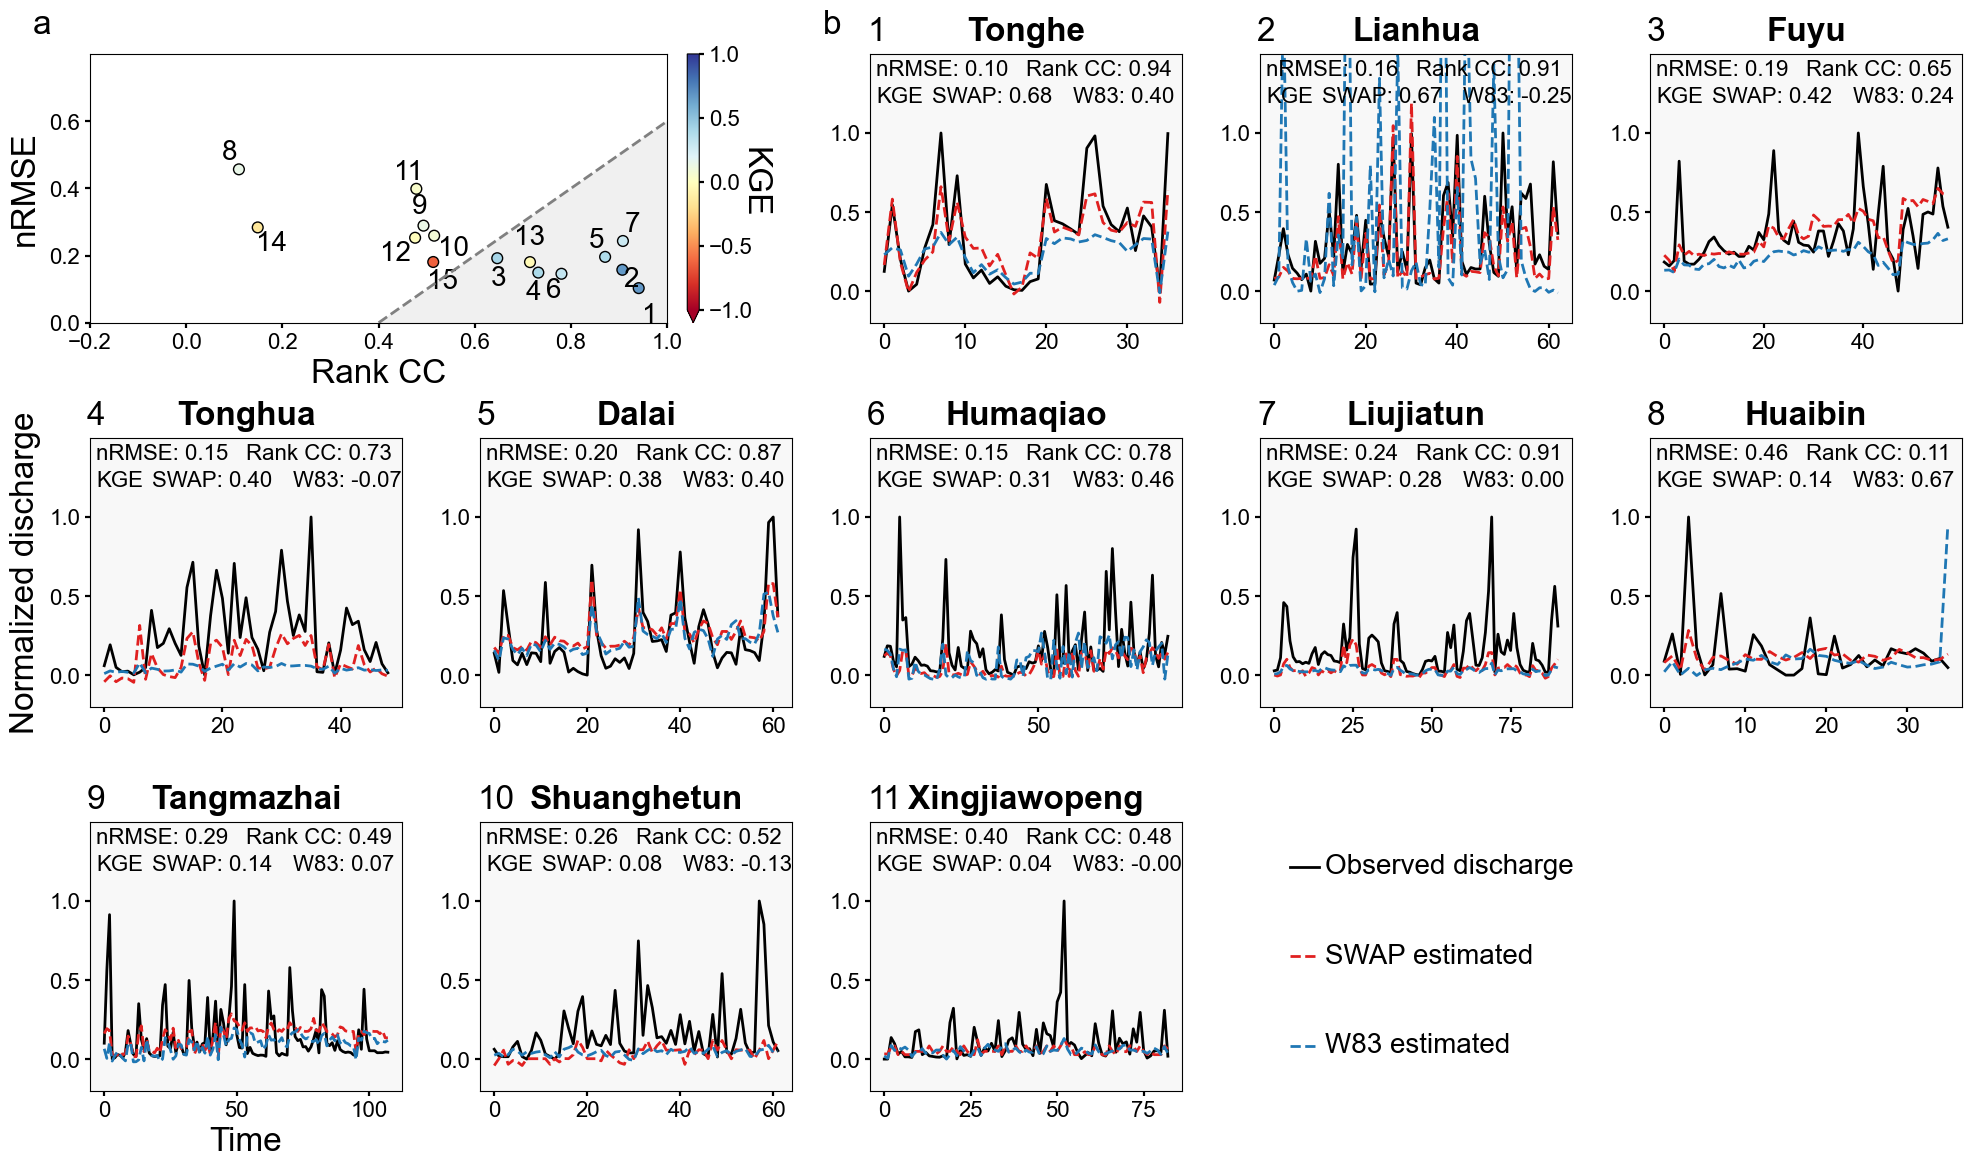

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors as mpc
from scipy.stats import spearmanr
from adjustText import adjust_text
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 16
plt.rcParams['axes.titlesize'] = 24
plt.rcParams['axes.labelsize'] = 24
plt.rcParams['axes.titlepad'] = 10
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['xtick.major.width'] = 1.6
plt.rcParams['ytick.major.width'] = 1.6

N = 3  # 3 rows
M = 5  # 5 columns
BOUNDS = [0.1, 0.12, 0.8, 0.7]
MARGIN_LEFT, MARGIN_RIGHT, MARGIN_BOT, MARGIN_TOP = 0.025, 0, 0.04, 0
subplot_width = (1 - MARGIN_LEFT - MARGIN_RIGHT) / M
subplot_height = (1 - MARGIN_TOP - MARGIN_BOT) / N
AXES_LEFT = MARGIN_LEFT + (np.arange(M) + BOUNDS[0]) * subplot_width
AXES_BOT = MARGIN_BOT + (np.arange(N) + BOUNDS[1]) * subplot_height
AXES_WIDTH = subplot_width * BOUNDS[2]
AXES_HEIGHT = subplot_height * BOUNDS[3]
fig = plt.figure(figsize=(20, 12))  # Adjusted height for 3 rows
ax = [[plt.axes([AXES_LEFT[j], AXES_BOT[i], AXES_WIDTH, AXES_HEIGHT])\
       for j in range(M)] for i in np.arange(N-1,-1,-1)]

df_q_all = pd.read_csv('./3-process/5.q_kge_med_modified_q50_iqr_node_1.5_noqa_VersionD.csv').rename(columns = {'kge':'KGE','nrmse':'nRMSE'}) 
df_q_all = df_q_all[~df_q_all['stationid'].isin(['longmenzhen'])].reset_index(drop=True)
df_metrics = pd.read_csv('./4-validation/swot_hypso_metrics.csv')
df_metrics = df_metrics[~df_metrics['stationid'].isin(['longmenzhen'])].set_index('stationid')
stations = df_q_all.drop_duplicates(subset='stationid', keep='first').sort_values('KGE', ascending=False).reset_index(drop=True)['stationid']

df_q_w83_all = pd.read_csv('q_83.csv')
df_metrics_w83 = pd.read_csv('validation_83_datematch.csv').set_index('stationid')

# First loop: calculate metrics for ALL 15 stations (for scatter plot)
for idx in range(15):
    s = stations[idx]
    df_q = df_q_all[df_q_all['stationid']==s].copy().sort_values('date').reset_index(drop=True).drop_duplicates(subset='date')
    kge = df_q.iloc[0]['KGE']
    corr_val = spearmanr(df_q['width'], df_q['qobs'])
    nrmse = df_metrics.loc[s,'nrmse']
    df_metrics.loc[s,'kge'] = kge
    df_metrics.loc[s,'corr'] = corr_val.statistic
    df_metrics.loc[s,'number'] = idx + 1  # 1-15

# Second loop: plot time series for panels 2-13 (11 panels)
for panel in range(2, 13):
    s = stations[panel-2]
    i, j = int(panel / M), panel % M
    df_q = df_q_all[df_q_all['stationid']==s].copy().sort_values('date').reset_index(drop=True).drop_duplicates(subset='date')
    df_q_w83 = df_q_w83_all[df_q_w83_all['stationid']==s]
    df_q_w83 = df_q_w83[df_q_w83['date'].isin(df_q['date'])].drop_duplicates(subset='date')
    kge_w83= df_metrics_w83.loc[s,'KGE']
    kge = df_q.iloc[0]['KGE']
    corr_val = spearmanr(df_q['width'], df_q['qobs'])
    nrmse = df_metrics.loc[s,'nrmse']
    qmin, qmax = df_q['qobs'].min(), df_q['qobs'].max()
    Q_normalize = (df_q['qobs'] - qmin) / (qmax - qmin)
    Q_est_normalize = (df_q['Q_est'] - qmin) / (qmax - qmin)
    Q_est_normalize_w83 = (df_q_w83['83Q'] - qmin) / (qmax - qmin)

    ax[i][j].plot(np.arange(len(df_q)), Q_normalize, color='black', lw=2, zorder=0)
    ax[i][j].plot(np.arange(len(df_q)), Q_est_normalize, color='#E02020', lw=2, ls='--', zorder=1)
    ax[i][j].plot(np.arange(len(df_q)), Q_est_normalize_w83, color='#1f77b4', lw=2, ls='--', zorder=1)
    
    y0, ymax = ax[i][j].get_ylim()
    ymax = max(np.max(Q_normalize), np.max(Q_est_normalize))
    ax[i][j].set_ylim(y0, 1.3 * ymax)
    ax[i][j].set_yticks([0,0.5,1])
    ax[i][j].set_title(s.capitalize(), fontweight='bold')
    ax[i][j].set_facecolor('#F8F8F8')

    x0, xmax = ax[i][j].get_xlim()
    y0, ymax = ax[i][j].get_ylim()
    fig_w = xmax - x0
    ax[i][j].set_ylim(-0.2, 1.5)
    
    ymin, ymax = ax[i][j].get_ylim()
    fig_h = ymax - ymin
    ax[i][j].text(x0 + 0.02 * fig_w, ymin + 0.88 * (ymax - ymin), 'KGE', ha='left', va='top')
    ax[i][j].text(x0 + 0.20 * fig_w, ymin + 0.88 * (ymax - ymin), 'SWAP: %.2f' % kge, ha='left', va='top')
    ax[i][j].text(x0 + 0.65 * fig_w, ymin + 0.88 * (ymax - ymin), 'W83: %.2f' % kge_w83, ha='left', va='top')
    ax[i][j].text(x0 + 0.02 * fig_w, ymin + 0.98 * (ymax - ymin), 'nRMSE: %.2f' % nrmse, ha='left', va='top')
    ax[i][j].text(x0 + 0.50 * fig_w, ymin + 0.98 * (ymax - ymin), 'Rank CC: %.2f' % corr_val.statistic, ha='left', va='top')
    
    # Panel number in top left corner
    ax[i][j].text(x0 - 0.01 * fig_w, ymin + 1.025 * (ymax - ymin), '%d' % (panel - 1), fontsize=24, ha='left', va='bottom')
    
    ax[i][j].set_ylim(-0.2, 1.5)

    # Add 'b' label for first time series panel
    if panel == 2:
        ax[i][j].text(x0 - 0.15 * fig_w, ymin + 1.05 * fig_h, 'b', fontsize=24, ha='left', va='bottom')

# Turn off axes 13 and later (panel indices 13, 14)
for panel in range(13, 15):
    i, j = int(panel / M), panel % M
    ax[i][j].axis('off')

ax[N-1][0].set_xlabel('Time', labelpad=4)
ax[1][0].set_ylabel('Normalized discharge', labelpad=6)
ax[0][0].axis('off')
ax[0][1].axis('off')


# kge scatter plot with ALL 15 points
ax[0][0] = plt.axes([AXES_LEFT[0], AXES_BOT[N-1], 1.85*AXES_WIDTH, AXES_HEIGHT])
cax = plt.axes([AXES_LEFT[0]+1.85*AXES_WIDTH+0.01, AXES_BOT[N-1], 0.006, AXES_HEIGHT])

# Filter df_metrics to only include stations with valid values
df_metrics_plot = df_metrics.dropna(subset=['number', 'corr', 'nrmse', 'kge'])

ax[0][0].scatter(df_metrics_plot['corr'], df_metrics_plot['nrmse'], c=df_metrics_plot['kge'], cmap='RdYlBu',
                 s=60, lw=1, ec='black', vmin=-1, vmax=1)
ax[0][0].plot([0.4,1], [0,0.6], color='#808080', lw=2, ls='--')
anno = [ax[0][0].text(x=df_metrics_plot.loc[i,'corr'], y=df_metrics_plot.loc[i,'nrmse'], s=int(df_metrics_plot.loc[i,'number']),
                      fontsize=20, ha='center', va='center', zorder=1) for i in df_metrics_plot.index]
adjust_text(texts=anno, expand=(1.5,1.5), pull_threshold=50, explode_radius=100, ax=ax[0][0])
ax[0][0].fill_between([0.4,1], [0,0], [0,0.6], color='#F0F0F0', zorder=-1)

norm = mpc.Normalize(vmin=-1, vmax=1)
sm = plt.cm.ScalarMappable(cmap='RdYlBu', norm=norm)
cbar = fig.colorbar(sm, cax=cax, extend='min')
cbar.set_label('KGE', rotation=270, labelpad=12)

ax[0][0].set_yticks(np.arange(0,0.7,0.2))
ax[0][0].set_xlabel('Rank CC', labelpad=4)
ax[0][0].set_ylabel('nRMSE', labelpad=6)
ax[0][0].set_xlim(-0.2,1)
ax[0][0].set_ylim(0,0.8)

# Add 'a' label for scatter plot
x0_scatter, xmax_scatter = ax[0][0].get_xlim()
y0_scatter, ymax_scatter = ax[0][0].get_ylim()
fig_w_scatter = xmax_scatter - x0_scatter
fig_h_scatter = ymax_scatter - y0_scatter
ax[0][0].text(x0_scatter - 0.1 * fig_w_scatter, y0_scatter + 1.05 * fig_h_scatter, 'a', fontsize=24, ha='left', va='bottom')


ax[2][3].plot([0.5, 1.5], [2.5, 2.5], color='black', lw=2)  # Observed - black solid
ax[2][3].plot([0.5, 1.5], [1.5, 1.5], color='#E02020', lw=2, ls='--')  # SWAP - red dashed
ax[2][3].plot([0.5, 1.5], [0.5, 0.5], color='#1f77b4', lw=2, ls='--')  # W83 - blue dashed

ax[2][3].text(1.7, 2.5, 'Observed discharge', fontsize=20, ha='left', va='center')
ax[2][3].text(1.7, 1.5, 'SWAP estimated', fontsize=20, ha='left', va='center')
ax[2][3].text(1.7, 0.5, 'W83 estimated', fontsize=20, ha='left', va='center')

ax[2][3].set_xlim(-0.5, 10)
ax[2][3].set_ylim(0, 3)
ax[2][3].axis('off')


#plt.show()
plt.savefig('Fig8_w83.png', dpi=200)

In [4]:
print(df_metrics_plot)

                     r2      rmse     nrmse       kge      corr  number
stationid                                                              
changjiangtun  0.289856  0.549823  0.252924 -0.014073  0.475785    12.0
dalai          0.111237  0.607031  0.195982  0.380731  0.870809     5.0
fuyu           0.286013  0.610340  0.191992  0.416344  0.646563     3.0
heishiguan     0.020579  0.542734  0.283635 -0.149916  0.148570    14.0
huaibin        0.188530  0.966422  0.456506  0.141946  0.109488     8.0
humaqiao       0.333842  0.430854  0.145699  0.306388  0.780042     6.0
lianhua        0.434868  0.371390  0.157545  0.671434  0.906606     2.0
liujiatun     -0.095008  0.469267  0.243239  0.280434  0.907848     7.0
luanxian       0.154003  0.502264  0.180754 -0.633860  0.513448    15.0
shihuiyao     -0.050870  0.305775  0.180383 -0.032471  0.714636    13.0
shuanghetun   -0.192358  0.435647  0.258982  0.078655  0.515414    10.0
tangmazhai     0.443497  0.488992  0.288901  0.139504  0.493189 

In [8]:
df = df_metrics_plot[(df_metrics_plot['nrmse'] < 0.5) & (df_metrics_plot['corr'] > 0.5)]
print(df)

                   r2      rmse     nrmse       kge      corr  number
stationid                                                            
dalai        0.111237  0.607031  0.195982  0.380731  0.870809     5.0
fuyu         0.286013  0.610340  0.191992  0.416344  0.646563     3.0
humaqiao     0.333842  0.430854  0.145699  0.306388  0.780042     6.0
lianhua      0.434868  0.371390  0.157545  0.671434  0.906606     2.0
liujiatun   -0.095008  0.469267  0.243239  0.280434  0.907848     7.0
luanxian     0.154003  0.502264  0.180754 -0.633860  0.513448    15.0
shihuiyao   -0.050870  0.305775  0.180383 -0.032471  0.714636    13.0
shuanghetun -0.192358  0.435647  0.258982  0.078655  0.515414    10.0
tonghe       0.435417  0.676602  0.102955  0.675151  0.940658     1.0
tonghua     -0.669380  0.390518  0.149200  0.396883  0.731925     4.0
